In [6]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colorbar import Colorbar
import astropy.io.fits as pyfits
import scipy.optimize as opt
import corner
import os
import utils as myUtils
import scipy.integrate as integrate
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
from scipy import stats
import arviz




In [8]:
path = r'G:\Mi unidad\Universidad\Master_Astro\TFM\ALMA_images\Original\\'
sources = os.listdir(path)
# file = 17

fits_file  = pyfits.open(path+'cont_clean_LESS101_allspw_briggs_new.image.fits')
image_data = fits_file[0].data[0][0]
image_data.shape

(900, 900)

In [9]:
fits_file[0].header['OBSRA']

52.96498333333

In [10]:
fits_file[0].header['OBSDEC']

-27.76478333333

In [3]:
flux = myUtils.zoom(image_data,34)
flux = flux * 10**3

x = np.linspace(0, flux.shape[1], flux.shape[1])
y = np.linspace(0, flux.shape[0], flux.shape[0])
x, y = np.meshgrid(x, y)

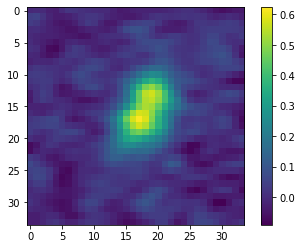

In [4]:
fig, ax = plt.subplots()
plt1 = ax.imshow(flux)
fig.colorbar(ax=ax, mappable=plt1, orientation='vertical')
plt.show()

In [5]:
np.where(flux==np.max(flux))
cuadrante_1 = flux[18:34,0:16]
cuadrante_2 = flux[0:16,0:16]

if sum(cuadrante_2.ravel()>=0.5) > sum(cuadrante_1.ravel()>=0.5):
    row, col = np.where(cuadrante_2 == np.max(cuadrante_2))
    r = np.sqrt(row**2 +col**2)
    angle = 180 - np.arcsin(col/r) * 180/np.pi
    
else:
    row, col = np.where(cuadrante_1 == np.max(cuadrante_1))
    r = np.sqrt(row**2 +col**2)
    angle = np.arcsin(col/r) * 180/np.pi

In [6]:
I = flux

M0 = I.sum()
x0 = (x*I).sum()/M0
y0 = (y*I).sum()/M0
Mxx = (x*x*I).sum()/M0 - x0*x0
Myy = (y*y*I).sum()/M0 - y0*y0
Mxy = (x*y*I).sum()/M0 - x0*y0
D = 2*(Mxx*Myy-Mxy*Mxy)
a = Myy/D
b = Mxx/D
c = -Mxy/D


# Find the area of one pixel expressed in grids to find amplitude A
   
theta = np.degrees(0.5*np.arctan(2*c/(a-b))) 
if a-b > 0: # Not HW1 but the largest axis corresponds to theta.
    theta += 90.0
if theta < 0:
    theta += 180

In [7]:
print(angle, theta)

[90.] 33.73240143435279


In [8]:
# plt.hist(flux.ravel(),bins=100)
# stats.norm.fit(flux.ravel())[1]


In [9]:
# stats.lognorm.fit(flux.ravel()+1e-10)
# param=stats.lognorm.fit(flux.ravel()+1e-10) # fit the sample data
# x=np.linspace(0,1,1000)
# pdf_fitted = stats.lognorm.pdf(x, param[0], loc=param[1], scale=param[2]) # fitted distribution
# plt.plot(x,pdf_fitted)

In [11]:
popt, pcov = myUtils.get_parameter_curve_fit(flux,x,y,profile='C')
# mu_x, mu_y, sigma_y, sigmax_minus_y, amplitude, angle, offset = popt
x_0, y_0, sigma_y, sigmax_minus_y, amplitude, theta, offset, amplitude_sersic, r_eff, n, ellip, angle_sersic = popt
# sigma_x = sigma_y + np.abs(sigmax_minus_y)
# print(mu_x, mu_y,sigma_x, sigma_y, angle, sigmax_minus_y)

In [12]:
x_0

18.52627321012969

In [11]:
ndim, nwalkers = 7, 50
# pos = [amplitude, 17, 17, sigma_x, sigma_y, angle,offset]
# pos = [np.abs(np.random.normal(pos, 0.2)) for i in range(nwalkers)] # initialing araund a normal with mu equal to curvfit values

#pos = [np.random.uniform(0.8,1.2,size=ndim) * np.array(pos)  for i in range(nwalkers)]
#pos = [np.random.uniform(-0.5,0.5,size=ndim) + np.array(pos)  for i in range(nwalkers)]


In [12]:
dtype = [("log_likelihood_", object)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, myUtils.log_probability, 
                                args=[x.ravel(), y.ravel(), flux.ravel(),
                                      myUtils.std_image(flux), [mu_x, pcov[0,0], mu_y, pcov[1,1]]],blobs_dtype=object)

sampler.run_mcmc(pos, 2000, progress=True);

emcee: Exception while calling your likelihood function:
  params: [ 0.29928416 16.82921102 16.92824203  4.32654589  2.69655986 64.42526488
  0.11617958]
  args: [array([ 0.        ,  1.03030303,  2.06060606, ..., 31.93939394,
       32.96969697, 34.        ]), array([ 0.,  0.,  0., ..., 34., 34., 34.]), array([-0.00982907, -0.0066126 , -0.00699894, ..., -0.01246907,
       -0.00340591,  0.01575913], dtype=float32), 0.02817942, [18.526380352898123, 0.0015599236251066435, 16.186870002274993, 0.002956869752335291]]
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "d:\python37\lib\site-packages\emcee\ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "G:\Mi unidad\Universidad\Master_Astro\TFM\codes\Gaussian fitting\utils.py", line 158, in log_probability
    return lp + sum(log_likelihood_), float(log_likelihood_)
TypeError: only size-1 arrays can be converted to Python scalars


TypeError: only size-1 arrays can be converted to Python scalars

In [114]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

# print(
#     "Mean autocorrelation time: {0:.3f} steps".format(
#         np.mean(sampler.get_autocorr_time())
#     )
# )

Mean acceptance fraction: 0.486


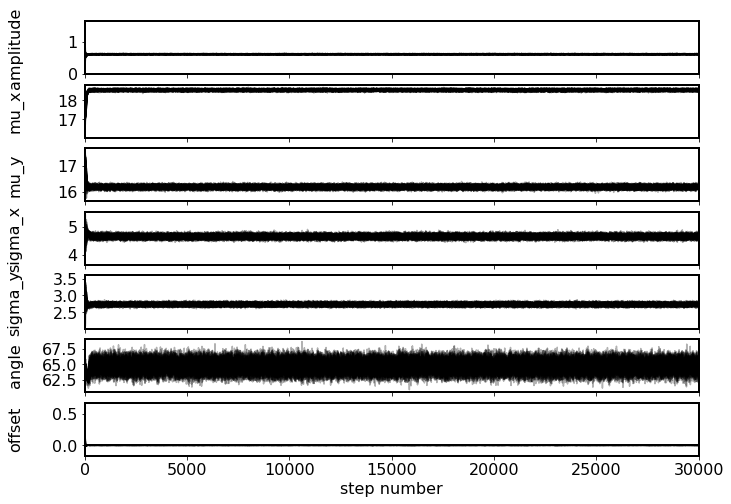

In [115]:
fig, axes = plt.subplots(7, figsize=(11, 8), sharex=True)
samples = sampler.get_chain()
labels = ['amplitude','mu_x', 'mu_y', 'sigma_x', 'sigma_y', 'angle', 'offset']
for i in range(7):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(149500, 7)


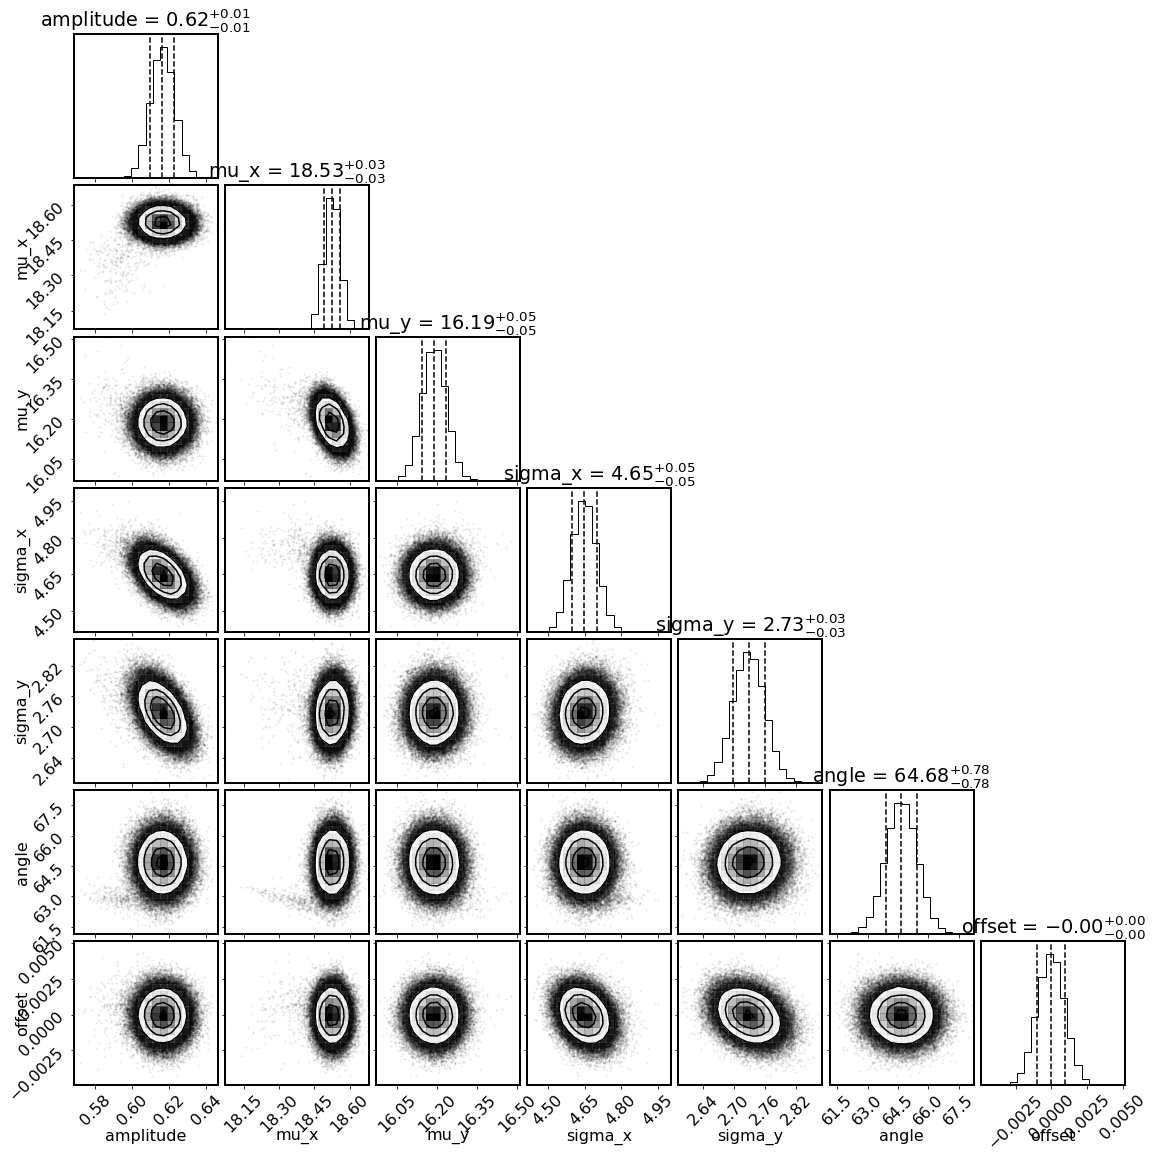

In [116]:
flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84],
                    show_titles=True)

In [16]:
parameters_fit_50 = []
parameters_fit_16 = []
parameters_fit_84 = []
#hdp = [] # highest posterior density (HPD) of array for given alpha 0.05
for j in range(ndim):
    mcmc = np.percentile(flat_samples[500:, j], [16, 50, 84])
    #hpd_, _, _, _ = myUtils.hpd_grid(flat_samples[100:, j])
    parameters_fit_50.append(mcmc[1])
    parameters_fit_16.append(mcmc[0])
    parameters_fit_84.append(mcmc[2])
   # hdp.append(hpd_)
#hdp = np.asarray(hdp)

In [40]:
amplitude_emcee, mu_x_emcee, mu_y_emcee, sigma_x_emcee, sigma_y_emcee, angle_emcee, offset_emcee = parameters_fit_50

In [18]:
fobs = myUtils.twoD_Gaussian_curvefit([x,y],mu_x_emcee, mu_y_emcee, sigma_x_emcee, sigma_y_emcee
                    , amplitude_emcee, angle_emcee, offset_emcee).reshape(x.shape[0],y.shape[1])

In [19]:
# read some parameters from the header useful to convert the map from pixels to RA and Dec
# x_center=fits_file[0].header['CRPIX1']
# y_center=fits_file[0].header['CRPIX2']
x_center = flux.shape[0]/2 
y_center = flux.shape[1]/2
ra_center=fits_file[0].header['CRVAL1']
dec_center=fits_file[0].header['CRVAL2']
dx=fits_file[0].header['CDELT1']
dy=fits_file[0].header['CDELT2']
bmaj=fits_file[0].header['BMAJ']*3600 #convert from degrees to arcsec
bmin=fits_file[0].header['BMIN']*3600
bpa=fits_file[0].header['BPA']


In [20]:
# x_center=fits_file[0].header['CRPIX1']
# y_center=fits_file[0].header['CRPIX2']
# print(x_center, y_center)

In [21]:
# from sigma to FWHM
FWHM_x_emcee = 2*np.sqrt(2*np.log(2)) * sigma_x_emcee
FWHM_y_emcee =  2*np.sqrt(2*np.log(2)) * sigma_y_emcee

sigmax_ang_emcee = np.abs(dx*3600)*sigma_x_emcee
sigmay_ang_emcee = np.abs(dy*3600)*sigma_y_emcee
amp_emcee = amplitude_emcee
theta_rad_emcee = angle_emcee # np.cos works with radians
x_cen_emcee = ((flux.shape[0]/2)-mu_x_emcee)*np.abs(dx*3600)
y_cen_emcee = ((flux.shape[1]/2)-mu_y_emcee)*np.abs(dy*3600)

print('pos', x_cen_emcee, y_cen_emcee, sigmax_ang_emcee, sigmay_ang_emcee, angle_emcee)


FWHM_x = 2*np.sqrt(2*np.log(2)) * sigma_x
FWHM_y = 2*np.sqrt(2*np.log(2)) * sigma_y

sigmax_ang = np.abs(dx*3600)*sigma_x
sigmay_ang = np.abs(dy*3600)*sigma_y
amp = popt[4]
theta_rad = popt[5] # np.cos works with radians
x_cen = ((flux.shape[0]/2)-popt[0])*np.abs(dx*3600)
y_cen = ((flux.shape[1]/2)-popt[1])*np.abs(dy*3600)
print('pos', x_cen, y_cen, sigmax_ang, sigmay_ang,popt[5])

pos -0.03813481236308474 0.0203021084291667 0.11625056861884987 0.0682479393092723 64.68003288973534
pos -0.03815950882245063 0.020328249943123867 0.1162115969795395 0.06820514139361047 64.68405395283271


In [18]:
# convert from pixel to relative RA and DEC
# centering on the image center or on the target -> x_center, y_center

flux2 = myUtils.zoom(image_data,70) * 10**3
x_center2 = flux2.shape[0]/2 
y_center2 = flux2.shape[1]/2 

x_extent = (np.array([0., flux2.shape[1]]) - (flux2.shape[1] - x_center2+0.5)) * dx*3600 * (-1)
y_extent = (np.array([0., flux2.shape[0]]) - (flux2.shape[0] - y_center2+0.5)) * dy*3600
extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]


NameError: name 'dx' is not defined

In [23]:
myUtils.std_image(flux2)

0.033154503

NameError: name 'flux2' is not defined

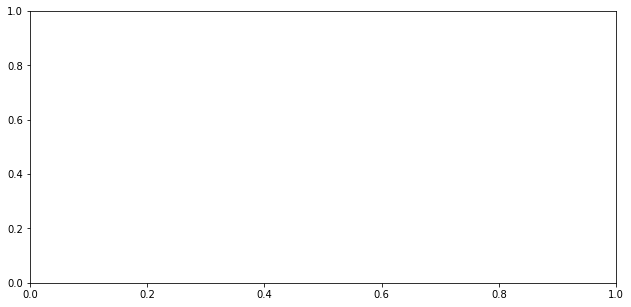

In [17]:


fig, ax = plt.subplots(nrows=1, ncols=1,sharey=True, sharex=True, figsize=(10.5,5))

plt1 = ax.imshow(flux2, cmap='YlOrRd', origin = 'lower', extent=extent,vmin=flux2.min(), vmax=flux.max())
rms = myUtils.std_image(flux2) #check rms
levels=[2*rms, 4*rms, 6*rms, 10 * rms, 15 * rms]
plt2 = ax.contour(flux2, levels, colors='k', alpha=0.8, linewidths=1.0,extent=extent)
# plot the best fit ellipse
fwhm_x = FWHM_x*np.abs(dx)*3600
fwhm_y = FWHM_y*dy*3600
pa_deg = 180 - theta_rad

x_cen_fit = (17-mu_x)*dx*3600#*(-1)
y_cen_fit = (17-mu_y)*dy*3600*(-1)

fit_ellipse = Ellipse((x_cen_fit,y_cen_fit), width=fwhm_x, height=fwhm_y, angle=pa_deg, 
                      facecolor='none', edgecolor='blue', alpha=1.0,lw=2, zorder=200)

ax.add_artist(fit_ellipse)
ax.legend(handles=[fit_ellipse],labels=['emcee ellipse'],fontsize=10)
ax.set_xlabel('Relative RA [arcsec]')
ax.set_ylabel('Relative Dec [arcsec]')



# plot the best fit ellipse emcee
fwhm_x_emcee = FWHM_x_emcee*np.abs(dx)*3600
fwhm_y_emcee = FWHM_y_emcee*dy*3600
pa_deg_emcee = 180 - theta_rad_emcee

x_cen_fit_emcee = (x_center-mu_x_emcee)*dx*3600#*(-1)
y_cen_fit_emcee = (y_center-mu_y_emcee)*dy*3600*(-1)

fit_ellipse_emcee = Ellipse((x_cen_fit_emcee,y_cen_fit_emcee), width=fwhm_x_emcee, height=fwhm_y_emcee, 
                            angle= pa_deg_emcee, facecolor='none', edgecolor='green', alpha=1.0,lw=2, zorder=200)

ax.add_artist(fit_ellipse_emcee)
ax.legend(handles=[fit_ellipse,fit_ellipse_emcee],labels=['Curve_fit ellipse','emcee ellipse'],fontsize=10)
ax.set_title('Source: ')


fobs2 = myUtils.twoD_Gaussian_curvefit([x2,y2],mu_x_emcee+shift, mu_y_emcee+shift,sigma_y_emcee, sigmax_ang_emcee-sigma_y_emcee,

                                       amplitude_emcee, angle_emcee, offset_emcee).reshape(x2.shape[0],y2.shape[1])

# plt3 = ax[1].imshow((flux2-fobs2), cmap='YlOrRd', origin = 'lower',extent=extent, vmin=flux2.min(), vmax=flux.max())
# ax[1].tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False) 
# rms = myUtils.std_image((flux2-fobs2)) 
# levels=[-8*rms, -6*rms, -4*rms, -2*rms,2*rms, 4*rms, 6*rms, 8*rms]
# plt4 = ax[1].contour((flux2-fobs2), levels, colors='k', alpha=0.8, linewidths=1.0,extent=extent)
# ax[1].set_xlabel('Relative RA [arcsec]')
# plt.subplots_adjust(left=0.125,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0, 
#                     hspace=0.35)


# cb = Colorbar(ax=ax[1], mappable=plt1, cmap='YlOrRd',orientation='vertical')
# cb.set_label(r'Flux density [$m$Jy/beam]')
# cb.tick_params(axis='y', direction='out')

cbar = fig.colorbar(plt1, ax=ax.ravel().tolist(), shrink=0.75, pad=0.01)
cbar.set_label(r'Flux density [$m$Jy/beam]')
ax.set_title('Residual map ')


In [ ]:
# plt.rcParams.update({'font.size': 14, 'axes.linewidth': 1.5})
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'xtick.labelsize':16})
plt.rcParams.update({'ytick.labelsize':16})
plt.rcParams.update({'axes.linewidth': 2})

fig = plt.figure(figsize=(7.5,7))
gs = gridspec.GridSpec(1,2,width_ratios=[0.3, 0.3,])
gs.update(wspace=0.01)
ax_plot = plt.subplot(gs[0,0])
# cbax = plt.subplot(gs[0,2])

plt1 = ax_plot.imshow(flux2, cmap='YlOrRd', origin = 'lower', extent=extent)
rms = myUtils.std_image(flux2) #check rms
levels=[2*rms, 4*rms, 6*rms, 8*rms]
plt2 = ax_plot.contour(flux2, levels, colors='k', alpha=0.8, linewidths=1.0,extent=extent)

# cb = Colorbar(ax=cbax, mappable=plt1, cmap='YlOrRd',orientation='vertical')
# cb.set_label(r'Flux density [$m$Jy/beam]')
# cb.ax.tick_params(axis='y', direction='out')

# plot the best fit ellipse
fwhm_x = FWHM_x*np.abs(dx)*3600
fwhm_y = FWHM_y*dy*3600
pa_deg = 180 - theta_rad

x_cen_fit = (17-mu_x)*dx*3600#*(-1)
y_cen_fit = (17-mu_y)*dy*3600*(-1)

fit_ellipse = Ellipse((x_cen_fit,y_cen_fit), width=fwhm_x, height=fwhm_y, angle=pa_deg, 
                      facecolor='none', edgecolor='blue', alpha=1.0,lw=2, zorder=200)

ax_plot.add_artist(fit_ellipse)
ax_plot.legend(handles=[fit_ellipse],labels=['emcee ellipse'],fontsize=10)
ax_plot.set_xlabel('Relative RA [arcsec]')
ax_plot.set_ylabel('Relative Dec [arcsec]')



# plot the best fit ellipse emcee
fwhm_x_emcee = FWHM_x_emcee*np.abs(dx)*3600
fwhm_y_emcee = FWHM_y_emcee*dy*3600
pa_deg_emcee = 180 - theta_rad_emcee

x_cen_fit_emcee = (x_center-mu_x_emcee)*dx*3600#*(-1)
y_cen_fit_emcee = (y_center-mu_y_emcee)*dy*3600*(-1)

fit_ellipse_emcee = Ellipse((x_cen_fit_emcee,y_cen_fit_emcee), width=fwhm_x_emcee, height=fwhm_y_emcee, 
                            angle= pa_deg_emcee, facecolor='none', edgecolor='green', alpha=1.0,lw=2, zorder=200)

ax_plot.scatter(x_cen_fit_emcee,y_cen_fit_emcee)
ax_plot.add_artist(fit_ellipse_emcee)
ax_plot.legend(handles=[fit_ellipse,fit_ellipse_emcee],labels=['Curve_fit ellipse','emcee ellipse'],fontsize=10)
ax_plot.set_title('Source: ' + sources[i] + r'\tiny hol')



ax_plot2 = plt.subplot(gs[0,1])
# cbax = plt.subplot(gs[0,3])

fobs2 = myUtils.twoD_Gaussian_curvefit([x2,y2],mu_x_emcee+shift, mu_y_emcee+shift,sigma_y_emcee, sigmax_ang_emcee-sigma_y_emcee,

                                       amplitude_emcee, angle_emcee, offset_emcee).reshape(x2.shape[0],y2.shape[1])

plt3 = ax_plot2.imshow((flux2-fobs2), cmap='YlOrRd', origin = 'lower',extent=extent)# rms = myUtils.std_image((flux2-fobs)) #check rms
rms = myUtils.std_image((flux2-fobs2)) #check rms
levels=[-8*rms, -6*rms, -4*rms, -2*rms,2*rms, 4*rms, 6*rms, 8*rms]
plt4 = ax_plot2.contour((flux2-fobs2), levels, colors='k', alpha=0.8, linewidths=1.0,extent=extent)


# x_id, y_id = np.where(flux2==np.max(flux2))
# x_id = (x_center2 + -x_id)*dx*3600#*(-1)
# y_id = (y_center2 + -y_id)*dy*3600*(-1)

# ax_plot.set_xlim(-0.1,0.1)
# ax_plot.set_ylim(-0.1,0.1)
# ax_plot.scatter(x_id,y_id,c = 'green')

plt.show()

In [ ]:
shift = (flux2.shape[1]-flux.shape[1])/2
x2 = np.linspace(0, flux2.shape[1], flux2.shape[1])
y2 = np.linspace(0, flux2.shape[0], flux2.shape[0])
x2, y2 = np.meshgrid(x2, y2)

NameError: name 'x2' is not defined

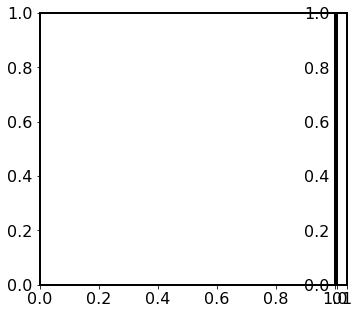

In [59]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'xtick.labelsize':16})
plt.rcParams.update({'ytick.labelsize':16})
plt.rcParams.update({'axes.linewidth': 2})

fig = plt.figure(figsize=(5.5,5))
gs = gridspec.GridSpec(1,2,width_ratios=[0.3,0.01])
gs.update(wspace=0.01)
ax_plot = plt.subplot(gs[0,0])
cbax = plt.subplot(gs[0,1])

fobs2 = myUtils.twoD_Gaussian_curvefit([x2,y2],mu_x_emcee+shift, mu_y_emcee+shift,sigma_y_emcee, sigmax_ang_emcee-sigma_y_emcee,

                                       amplitude_emcee, angle_emcee, offset_emcee).reshape(x2.shape[0],y2.shape[1])

plt3 = ax_plot.imshow((flux2-fobs2), cmap='YlOrRd', origin = 'lower',extent=extent)# rms = myUtils.std_image((flux2-fobs)) #check rms
rms = myUtils.std_image((flux2-fobs2)) #check rms
levels=[-8*rms, -6*rms, -4*rms, -2*rms,2*rms, 4*rms, 6*rms, 8*rms]
plt4 = ax_plot.contour((flux2-fobs2), levels, colors='k', alpha=0.8, linewidths=1.0,extent=extent)

cb = Colorbar(ax=cbax, mappable=plt3, cmap='YlOrRd',orientation='vertical')
cb.set_label(r'Flux density [$m$Jy/beam]')
cb.ax.tick_params(axis='y', direction='out')


In [13]:
like_samps = sampler.get_blobs()


In [62]:
like_samps['log_likelihood_'].shape

(30000, 50)

In [103]:
like_samps['log_likelihood_'][0][0]

array([1.15445838, 1.34536513, 1.3231233 , ..., 0.9880311 , 1.52272276,
       2.31274498])

In [111]:
import arviz
data = arviz.from_emcee(sampler, 
                        var_names = ['amplitude','mu_x', 'mu_y', 'sigma_x', 'sigma_y', 'angle', 'offset'],
                       )
# like_samps = sampler.get_blobs()
# like_samps_flat = np.zeros((like_samps.shape[0],like_samps.shape[1],34*34))

# for i in range(like_samps.shape[0]):
#     for j in range(like_samps.shape[1]):
#         like_samps_flat[i][j][:] =like_samps[i][j][0]


# data.add_groups(
#     log_likelihood = {"log likelihood": like_samps_flat.reshape(like_samps_flat.shape[1],like_samps_flat.shape[0],34*34)})

data.add_groups(
    log_likelihood = {"log likelihood": like_samps['log_likelihood_']})

In [120]:
data = arviz.from_emcee(sampler, 
                        var_names = ['amplitude','mu_x', 'mu_y', 'sigma_x', 'sigma_y', 'angle', 'offset'],
                       )
data.add_groups(
    log_likelihood = {"log likelihood": like_samps['log_likelihood_'].T})

KeyError: 'log likelihood'

In [ ]:
data = data.sel(draw=slice(1000, None))


In [111]:
l = data.log_likelihood['log likelihood'].stack(__sample__=("chain", "draw"))
(l.var(dim="__sample__")>0.4).sum()

<xarray.DataArray 'log likelihood' ()>
array(859)

In [ ]:
arviz.waic(data)

In [107]:
arviz.loo(data)

d:\python37\lib\site-packages\arviz\stats\stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
d:\python37\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
d:\python37\lib\site-packages\arviz\stats\stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 75000 posterior samples and 1156 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2071.84   262.14
p_loo     4337.17        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)         12    1.0%
   (0.7, 1]   (bad)       185   16.0%
   (1, Inf)   (very bad)  959   83.0%

In [105]:
n_data_points

1156

In [ ]:
compare_dict = {"non centered": data, "centered": data}
arviz.compare(compare_dict)

In [82]:
myUtils.bic( pos[0], x, y, flux, 7)

ValueError: The user-provided objective function must return a scalar value.

In [ ]:
# like_samps = sampler.get_blobs()
# like_samps_flat = np.zeros((2000,300,34*34))

# for i in range(like_samps.shape[0]):
#     for j in range(like_samps.shape[1]):
#         like_samps_flat[i][j][:] =like_samps[i][j][0]

# del(like_samps)
# like_samps_flat = like_samps_flat.reshape(2000*300, 1156)        

# # lpdi = np.log(np.mean(like_samps_flat,axis=0))
# vari = np.var(np.log(like_samps_flat),axis=0)
# # # del(like_samps_flat)
# # lpdimean = sum(lpdi)
# # pwaic = sum(vari) 
# # WAIC = -2*lpdimean + 2*pwaic 
# # WAIC